# 投资表现

## 加载模块

In [41]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## 读入文件

In [2]:
df_merge = pd.read_csv('../data/stock-accounting.csv')
df_merge['date'] = pd.to_datetime(df_merge['date'])

## 持有收益率

预处理：每个月的 `RET` 其实是本月相对于上个月的收益，故将 `RET` 上移一位，做到当月的股价与对应收益率相乘

In [3]:
df_ret = df_merge.copy()
df_ret['RET'] = df_merge.groupby('PERMNO')['RET'].shift(-1)
df_ret['RET'] = df_ret['RET'].fillna(0.)
df_ret['adj-prc'] = df_ret['adj-prc'].fillna(0.)

计算收益与时间的关系，适用于两种组合

In [45]:
time_series = df_ret['date'].unique()
time_series = np.sort(time_series)

idx_stg = ['Intro', 'Growth', 'Mature', 'Shakeout', 'Decline']

def share_amount(group):
    g = group.copy()
    amount = g['weight'] * g['stg-value'] * g['market-cap'] / g['market-cap'].sum()
    amount = amount / g['adj-prc']
    amount.fillna(0)
    amount.name = 'amount'
    return pd.concat([g['PERMNO'], amount], axis=1)

def value_date(df_ret, by):
    df_value = pd.DataFrame(columns=['date'] + idx_stg)
    df_value['date'] = time_series
    
    for i, row in df_value.iterrows():
        d = row['date']
        df_date = df_ret.loc[(df_ret['date'] == d) & df_ret['stg'].isin(idx_stg)].copy()
        df_date = df_date.sort_values('PERMNO')
        if ('industry' in by):
            inds_num = df_date['industry'].unique().shape[0]
            df_date['weight'] = 1 / inds_num
        else:
            df_date['weight'] = 1.
        df_date['stg-value'] = 0.
        
        if i == 0:
            df_value.loc[0, 'Intro': 'Decline'] = 1.
        for stg in idx_stg:
            df_date.loc[df_date['stg'] == stg, 'stg-value'] = df_value.loc[i, stg]
    
        df_amount = df_date.groupby(by)[['PERMNO', 'market-cap', 'adj-prc', 'stg-value', 'weight']].apply(share_amount).reset_index()
        df_amount = df_amount[['PERMNO', 'amount']]
        df_amount = df_amount.sort_values('PERMNO')
        df_date = pd.merge(
            df_date,
            df_amount,
            on='PERMNO',
            how='left'
        )
        df_date['value'] = (1 + df_date['RET']) * df_date['amount'] * df_date['adj-prc']
    
        if i < df_value.shape[0] - 1:
            df_value.loc[i + 1, 'Intro': 'Decline'] = df_date.groupby('stg')['value'].sum()
        print(i, end=' ')

    return df_value

### 市值加权组合

In [5]:
df_value = value_date(df_ret, 'stg')
df_value

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

,date,Intro,Growth,Mature,Shakeout,Decline
0,1989-01-31,1.0,1.0,1.0,1.0,1.0
1,1989-02-28,1.000894,0.979447,0.977912,1.00592,0.997966
2,1989-03-31,1.001664,1.00015,0.998453,1.031724,1.02713
3,1989-04-28,1.060683,1.054064,1.049755,1.092866,1.087381
4,1989-05-31,1.093052,1.115688,1.083767,1.130126,1.138011
...,...,...,...,...,...,...
403,2022-08-31,1.429263,22.615072,46.418938,27.895701,8.726271
404,2022-09-30,1.281998,20.426517,42.143736,24.864546,7.593699
405,2022-10-31,1.32125,21.367123,45.580554,28.491734,7.970976
406,2022-11-30,1.324376,21.93996,48.067325,29.898276,8.657153


### EXHIBIT 5 - Panel A

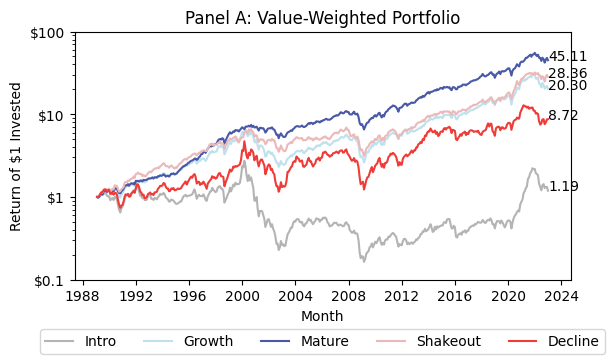

In [6]:
colors = ['#b4b4b5', '#bee1ed', '#4959a7', '#ebb9ba', '#ef3c39']
for stg, clr in zip(idx_stg, colors):
    plt.plot(df_value['date'], df_value[stg], label=stg, color=clr)
    last_row = df_value.iloc[-1]
    plt.text(last_row['date'], last_row[stg], '{:.2f}'.format(last_row[stg]))
plt.title('Panel A: Value-Weighted Portfolio')
plt.xlabel('Month')
plt.ylabel('Return of $1 Invested')
plt.ylim(0.1, 100)
plt.yscale('log')
plt.gca().set_yticks([0.1, 1, 10, 100])
plt.gca().set_yticklabels(['$0.1', '$1', '$10', '$100'])
plt.gca().set_box_aspect(0.5)
plt.legend(ncols=5, loc=[-0.07, -0.3])
plt.savefig('../exhibits/Exhibit5-PanelA.png')
plt.show()

### 行业加权组合

首先定义行业

In [30]:
df_ret['industry'] = ''

industry_name = ''
with open('../data/Siccodes10.txt', 'r') as file:
    for line in file.readlines():
        line_split = line
        line_split = line_split.replace('-', ' ')
        line_split = line_split.replace('\n', '')
        line_split = line_split.split(' ')
        line_split = list(filter(None, line_split))
        if (len(line_split) < 2):
            continue
        if (line_split[0].isdigit() and not line_split[1].isdigit()):
            industry_name = line_split[1]
        elif (line_split[0].isdigit() and line_split[1].isdigit()):
            low = int(line_split[0])
            high = int(line_split[1])
            df_ret.loc[df_ret['SICCD'].isin(range(low, high + 1)), 'industry'] = industry_name
df_ret['industry'] = df_ret['industry'].replace('', 'Other')

In [46]:
df_industry = value_date(df_ret, by=['stg', 'industry'])
df_industry

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

,date,Intro,Growth,Mature,Shakeout,Decline
0,1989-01-31,1.0,1.0,1.0,1.0,1.0
1,1989-02-28,0.998965,0.982233,0.977185,1.014604,1.001301
2,1989-03-31,1.017567,1.011226,0.994587,1.028428,1.034273
3,1989-04-28,1.081115,1.066605,1.045358,1.083907,1.085115
4,1989-05-31,1.130409,1.124009,1.079115,1.111409,1.116011
...,...,...,...,...,...,...
403,2022-08-31,0.09839,28.352588,41.103347,41.571492,1.029555
404,2022-09-30,0.087457,25.498955,37.335345,36.612909,0.892719
405,2022-10-31,0.091951,27.903904,41.572031,41.5692,0.988588
406,2022-11-30,0.090642,28.828465,43.633588,43.83806,1.003849


## 因子暴露